In [1]:
"""
python 2.7
The classifier is used in Brain v2.16. This code verifies that the saved model can be loaded by older version of the tensorflow
and work properly.
"""

from collections import defaultdict, Counter
import glob
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import scipy
import os
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow.keras as tk
import tensorflow.keras.layers as tkl

plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
def create_model(input_dim, output_dim, hidden_dim=128):
    layers = [
        tkl.Dense(hidden_dim, input_dim=input_dim),
        tkl.BatchNormalization(),
        tkl.ReLU(),
        tkl.Dense(hidden_dim, input_dim=input_dim),
        tkl.BatchNormalization(),
        tkl.ReLU(),
        tkl.Dense(output_dim, activation='linear'),
    ]
    model = tk.Sequential(layers)
    return model

In [3]:
# There is something different in layer naming between versions
filepath = 'face_model/amanosan_person1_person2_uedasan_weights.h5'
#filepath = 'face_model/amanosan_person2_weights.h5'
names = os.path.basename(filepath).split("_")[:-1]
model = create_model(128, len(names))
model.load_weights(filepath, by_name=False)

In [4]:
def load_embeddings(path, names=None):
    embeddings = []
    for user_embedding in glob.glob(path):
        if names:
            found_names = [name in user_embedding for name in names]
            if not any(found_names):
                continue
        with open(user_embedding, 'rb') as embed_file:
            user_info = pickle.load(embed_file, encoding='latin1')
            for user in user_info:
                embeddings.append(user)
    return embeddings

In [5]:
def create_dataset(embeddings, user_labels):
    x = []
    y = []
    for emb in embeddings:
        x.append(emb['embedding'].flatten())
        y.append(user_labels[emb["name"]])
    return np.array(x), np.array(y)

In [6]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
embeddings = load_embeddings("face_embeddings/*.emb", names={"amanosan", "person2"})  # these are Pascual and Priya
users = names
user_labels = {name: idx for idx, name in enumerate(users)}
print(users)
print(user_labels)
x, y = create_dataset(embeddings, user_labels)

['amanosan', 'person1', 'person2', 'uedasan']
{'amanosan': 0, 'person1': 1, 'person2': 2, 'uedasan': 3}


Accuracy 0.9750367107195301, precision 0.9750367107195301, recall 0.9750367107195301


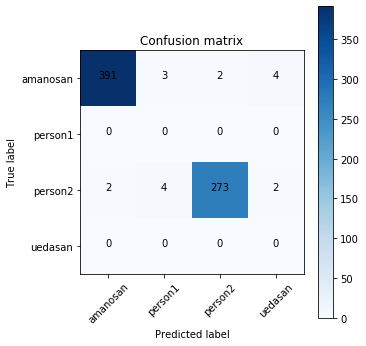

In [8]:
y_hat_logits = model.predict(x)
y_hat = np.argmax(y_hat_logits, axis=1)
accuracy = accuracy_score(y, y_hat)
precision = precision_score(y, y_hat, average='micro')
recall = recall_score(y, y_hat, average='micro')
cm = confusion_matrix(y, y_hat)
print("Accuracy {}, precision {}, recall {}".format(accuracy, precision, recall))
plot_confusion_matrix(cm, users)